# Generate views and texture images

## Load the metadata

The metadata pre-processed in notebook 1 contains the id's of the 3D-models that will be downloaded.

In [1]:
import pandas as pd
import os

# reload the cleaned-up data
metadata_df = pd.read_csv(os.path.join('data', 'metadata.csv'), index_col=False)

# after attempting to download the models, it apperas that some 3D-models are unavailable
unavailable = ['90ed2b7744134172bc8a24e37431ad39']
available_idx = [uid not in unavailable for uid in metadata_df.id]
metadata_df = metadata_df[available_idx]

print('There are {} 3D-models in the dataset.'.format(metadata_df.shape[0]))

There are 968 3D-models in the dataset.


## Download 3D models
I obtained 3D-models from the [Sketchfab website](https://sketchfab.com/3d-models/categories/cultural-heritage-history?date=week&features=downloadable&licenses=322a749bcfa841b29dff1e8a1bb74b0b&licenses=b9ddc40b93e34cdca1fc152f39b9f375&licenses=72360ff1740d419791934298b8b6d270&licenses=bbfe3f7dbcdd4122b966b85b9786a989&licenses=2628dbe5140a4e9592126c8df566c0b7&licenses=34b725081a6a4184957efaec2cb84ed3&licenses=7c23a1ba438d4306920229c12afcb5f9&licenses=783b685da9bf457d81e829fa283f3567&licenses=5b54cf13b1a4422ca439696eb152070d&sort_by=-likeCount). Sketchfab provides an [API](https://docs.sketchfab.com/data-api/v3/index.html#!/models/get_v3_models_uid_download) for querying and downloading 3D-models. I contacted Sketchfab to check if it would be alright to download a large number of 3D-models. They have been very supportive to my idea and I managed to use the API to download all the metadata and the 3D-models. 
The API requires a Sketchfab account and a key. The key is stored in the file `client_credentials.json` (not included in the submission). Please note that:
* 3D-models are large files. The project should require an estimated 20 GB of data, 17 GB for the downloaded files alone. I setup a virtual storage with 50 GB to hold the data for this project. Github recommends keeping projects under 5 GB. Therefore I will not be able to upload the 3D-models as such to the capstone repository, but only the pre-processed files. 
* the Sketchfab API has various download rate restrictions (per day, per hour, per minute), so that the download process has to be extended over a period of several days.

The downloaded 3D-models are stored as zip-compressed files on an external disk. As explained above, this data is too large for GitHub.

In [2]:
import json
import requests
import os
import time

# load credentials stored in local file
with open('client_credentials.json') as file:
    client_credentials = json.load(file)
API_TOKEN = client_credentials['api_token'] # Token from Sketchfab account

DOWNLOAD_DIR = '/mnt/Disk2/downloaded_models' # Folder to store the downloaded files
DOWNLOAD_DELAY = 20 # seconds, 200 / hour API rate limit
DOWNLOAD_ENDPOINT = 'https://api.sketchfab.com/v3/models/{}/download' # API endpoint

# HTTP request headers
headers = {'Authorization': 'Token {}'.format(API_TOKEN)} # Authorization method used
headers.update({'Content-Type': 'application/json'}) # http content type of the request

def download_data(uid):
    """
    Downloads a 3D-model from Sketchfab, saves it to a zipped file.
    @param: uid unique id of the model
    @raises: RequestException, e.g. API limit exceeded
    """
    # get the download url of the model
    # this url is only valid for a few minutes
    r = requests.get(
        DOWNLOAD_ENDPOINT.format(uid),
        headers = headers
    )
    r.raise_for_status() # throw exception if request status is not OK
    model_link = json.loads(r.text)
    url = model_link['gltf']['url'] # download url of the model

    # download the 3D-model, save it to file
    r = requests.get(url)
    with open(filename,'wb') as output_file:
        output_file.write(r.content)
            

try:
    # loop through the metadata table and download each 3D-model
    total = len(metadata_df)
    counter = 1
    verbose = False
    for model_uid in metadata_df['id']:
        filename = os.path.join(DOWNLOAD_DIR, '{}.zip'.format(model_uid)) # file to save the 3D-model
        if os.path.isfile(filename): # check that the file hasn't been downloaded already
            if verbose:
                print('File {} already exists'.format(filename))
        else:
            print('Downloading model {} ({}/{})'.format(model_uid, counter, total))
            download_data(model_uid) # download and save the 3D-model
            time.sleep(DOWNLOAD_DELAY) # don't hit the API too hard
        counter += 1

# Downloads may fail, typically when API limit exceeded
except requests.exceptions.RequestException:
    print('Download failed for 3D-model: {}'.format(model_uid))


In [3]:
print('The output of this step is: a folder with {} compressed files of 3D-models.'.format(
    len([
        name for name in os.listdir(DOWNLOAD_DIR) 
        if os.path.isfile(os.path.join(DOWNLOAD_DIR, name))
    ])
))

The output of this step is: a folder with 968 compressed files of 3D-models.


## Pre-process 3D-models

<img src="fig/point_cloud_texture.png">

_Figure 3: A Greek jug (A), its 3D point cloud (B), its texture image (C)._

After extracting the texture and the point cloud data from each 3D-model (fig. 3), I applied these steps (detailed in the following notebook cells):

__Point clouds__
1. subsample point cloud data so that the number of vertices is the number computed in the EDA in notebook 1, i.e. 37838 vertices
2. rotate the point cloud to generate an elevation (side) view
3. generate plan (top) and cross-section views by rotating the elevation view
4. render the views as images
5. save the pixel data of the flattened images into a npz file

__Textures__
1. resize the texture image to the size expected by the data extraction model, i.e. 299x299 pixels RGB
2. save the textures as flattened images into a npz file

The classifiers I implemented use either point cloud or texture data for input, so organizing these data separately at this stage will be beneficial later on. 

### Implement functions to decode GLTF files
3D-Models provided by the API are in Graphics Language Transmission Format (glTF). I implemented a function to read this kind of files using the open source [pygltflib library](https://pypi.org/project/pygltflib/). This library is __not included in the course environment, but can be installed using pip__. 

In [4]:
import zipfile
from pygltflib import GLTF2, BufferFormat
import struct
import numpy as np
import warnings
warnings.filterwarnings("ignore") # the gltf loader raises some unecessary warning
from PIL import Image
from PIL.Image import DecompressionBombError

DOWNLOAD_DIR = '/mnt/Disk2/downloaded_models' # Folder where the downloaded files are stored
TEMP_DIR = '/mnt/Disk2/temp' # Folder to temporarily extract the zipped files

def read_vertices(unzip_dir):
    """
    Reads a model's point cloud
    @param unzip_dir string, path to folder where gltf file was unzipped
    @returns numpy array of all vertices (3D-coordinates) in the 3D-model
    """
    # After unzipping the file, open its "scene" data
    filename = os.path.join(unzip_dir, 'scene.gltf') # the "scene" file is always called scene.gltf
    gltf = GLTF2().load(filename)
    # load the binary data contained in the "scene.bin" file into the gltf object
    gltf.convert_buffers(BufferFormat.DATAURI)

    # get the vertices for each primitive in each mesh
    vertices = []
    for mesh in gltf.meshes:
        for primitive in mesh.primitives:

            # get the binary data for this mesh primitive from the buffer
            accessor = gltf.accessors[primitive.attributes.POSITION]
            bufferView = gltf.bufferViews[accessor.bufferView]
            buffer = gltf.buffers[bufferView.buffer]
            data = gltf.decode_data_uri(buffer.uri)

            # pull each vertex from the binary buffer and convert it into a tuple of python floats
            for i in range(accessor.count):
                index = bufferView.byteOffset + accessor.byteOffset + i*12  # the location in the buffer of this vertex
                d = data[index:index+12]  # the vertex data
                v = struct.unpack("<fff", d)   # convert from base64 to three floats
                vertices.append(v)

    # convert the vertices to a numpy array
    vertices_np = np.array(vertices)
    return vertices_np


def read_texture(unzip_dir):
    """
    Reads a model's texture
    @param unzip_dir string, path to folder where gltf file was unzipped
    @returns PIL Image
    """
    texture = None
    textures_dir = os.path.join(unzip_dir, 'textures')
    if os.path.isdir(textures_dir): # check that the textures folder exists
        for _,_,files in os.walk(textures_dir):
            for file in files:
                if ('jpg' in file) or 'jpeg' in file:
                    texture = Image.open(os.path.join(textures_dir, file))
                    break
            if texture is not None: break
    return texture


def extract_gltf(model_uid):
    """
    Extracts the point cloud data from a gltf file as a numpy array.
    The returned array contains the 3D coordinates of all points in the point cloud.
    @param model_uid, string, id of a model
    @returns a numpy array of 3D coordinates
    """
    try:
        # create a temporary folder to extract this file
        unzip_dir = os.path.join(TEMP_DIR, model_uid)
        os.mkdir(unzip_dir)

        # unzip the downloaded 3D-model
        filename_zipped = os.path.join(DOWNLOAD_DIR, '{}.zip'.format(model_uid)) # zip file containing the the 3D-model
        with zipfile.ZipFile(filename_zipped, 'r') as zip_file:
            zip_file.extractall(unzip_dir)

        # read the model's point cloud
        vertices_np = read_vertices(unzip_dir)
        # read the 3D-models texture
        texture = read_texture(unzip_dir)
        
        return vertices_np, texture
    
    except DecompressionBombError as error:
        # image fils is too large
        print(error)
        return vertices_np, None
    
    finally:
        # whatever happens, delete the temporary folder
        os.remove(os.path.join(unzip_dir, 'scene.gltf'))
        os.remove(os.path.join(unzip_dir, 'scene.bin'))
        if os.path.isfile(os.path.join(unzip_dir, 'license.txt')):
            os.remove(os.path.join(unzip_dir, 'license.txt'))
        # remove texture
        textures_dir = os.path.join(unzip_dir, 'textures')
        if os.path.isdir(textures_dir): # check that the textures folder exists
            for _,_,files in os.walk(textures_dir):
                for file in files:
                    os.remove(os.path.join(textures_dir, file))
            os.rmdir(textures_dir)
        os.rmdir(unzip_dir)

### Implement a function to subsample point clouds
3D-models with a large number of vertices (up to several million) have a blotched appearance when rendered. Reducing the number of vertices brings up more detail (notebook 1, fig. 6) and increases processing speed. In notebook 1, I discarded the 5% of models with the least vertices. In this notebook, I subsampled the vertices in each 3D-model to the minimum number of vertices in the dataset prepared in notebook 1.

In [5]:
MAX_VERTICES = metadata_df['vertexCount'].min() # the lowest vertex count of any model in the dataset
print('The 3D-models will be subsampled to {} vertices.'.format(MAX_VERTICES))

def subsample_model(vertices_np):
    """
    Reduces the number of vertices in the 3D-model.
    @param vertices_np np array as returned by extract_gltf()
    @returns np array with MAX_VERTICES vertices
    """
    return pd.DataFrame(vertices_np).sample(n=MAX_VERTICES, random_state=0).to_numpy()

The 3D-models will be subsampled to 37498 vertices.


### Implement a function to resize textures
Read each 3D-model's texture and resize it to the size expected by the classifier.

In [6]:
# width and height of the image, as expected by the TF model, in pixels
TF_SIZE = 299

def resize_texture(texture):
    """
    Resizes a texture image to the size expected by the classifier.
    @param texture PIL Image
    @returns flattened np array of rgb values
    """
    texture = texture.resize((TF_SIZE, TF_SIZE), Image.BILINEAR)
    return np.array(texture).flatten()

### Read all downloaded 3D-models

Open the downloaded 3D-models, subsample the vertices, resize the textures:

In [7]:
# get a list of all 3D-models that have been downloaded
downloaded_uid = [model_uid for model_uid in metadata_df['id'] if os.path.isfile(os.path.join(DOWNLOAD_DIR, '{}.zip'.format(model_uid)))]
# some models are in several collections, so drop duplicates. Don't convert to set, as set will reorder the entries 
downloaded_uid = list(dict.fromkeys(downloaded_uid).keys())

# read the point cloud and subsample the vertices to MAX_VERTICES
vertices = []
textures = []
for model_uid in downloaded_uid:
    vertices_np, texture = extract_gltf(model_uid)
    vertices_np = subsample_model(vertices_np)
    vertices.append(vertices_np)
    if texture is not None:
        texture = resize_texture(texture)
    textures.append(texture)

Image size (268435456 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Image size (268435456 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Image size (268435456 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Image size (268435456 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Image size (268435456 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Image size (268435456 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Image size (268435456 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Image size (268435456 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


In [8]:
print('The output of this step is:\n\
    A "vertices" list of {} point clouds ({}), each containing the 3D coordinates of {} points.\n\
    A "textures" list of {} flattened images ({}) of size {}, i.e. {}*{} pixels, 3 channels (or None if the 3D-model has no texture).'.format(
    len(vertices), type(vertices[0]), vertices[0].shape[0],
    len(textures), type(textures[-1]), textures[-1].size, TF_SIZE, TF_SIZE
))

The output of this step is:
    A "vertices" list of 968 point clouds (<class 'numpy.ndarray'>), each containing the 3D coordinates of 37498 points.
    A "textures" list of 968 flattened images (<class 'numpy.ndarray'>) of size 268203, i.e. 299*299 pixels, 3 channels (or None if the 3D-model has no texture).


In [9]:
# save vertices and textures
NPZ_DIR = '/mnt/Disk2/temp' # temp files

# save rendered views to compressed file
np.savez_compressed(os.path.join(NPZ_DIR, 'vertices_temp.npz'), 
        downloaded_uid = downloaded_uid,
        vertices = vertices
        )
np.savez_compressed(os.path.join(NPZ_DIR, 'textures_temp.npz'), 
        downloaded_uid = downloaded_uid,
        textures = textures          
        )

In [10]:
import numpy as np
import os

NPZ_DIR = '/mnt/Disk2/temp' # temp files

# Load the numpy .npz file
with np.load(os.path.join(NPZ_DIR, 'vertices_temp.npz'), allow_pickle=True) as data:
    vertices_data = dict(data.items())

downloaded_uid = vertices_data['downloaded_uid']
vertices = vertices_data['vertices']

# Load the numpy .npz file
with np.load(os.path.join(NPZ_DIR, 'textures_temp.npz'), allow_pickle=True) as data:
    textures_data = dict(data.items())
textures = textures_data['textures']


## Generate views
A 3D-model cannot be represented by a single 2D view. Therefore, following archaeological practice, each object will be represented by an elevation view (from the side), a plan view (from the top) and a cross-section. 
* the elevation view (side)
* the plan view (top) is generated by rotating the elevation view by 90° degrees
* the cross-section view shows the points close to a vertical plane passing through the middle of the object 

### Elevation view
Generally, the scanning device's origin position is located above the object. Therefore, the 3D-model has to be rotated 90° clockwise in order to show  the object from the side ("elevation view").
During mass digitization, objects are placed on a conveyor belt and moved under the 3D scanning device (notebook 1, fig. 1). Therefore, objects have to be placed in a stable balanced position. Sometimes this means placing the object facing down on the belt, therefore some objects have to be rotated 90° anti-clockwise. Additionally, some objects, particularly the broken ones, require a custom rotation. I examined each object individually and stored the required rotation in the file `data/rotation.csv`.

In [11]:
import pandas as pd
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist

def rotate(point_cloud, rotation):
    """
    Rotates 3D model.
    @param point_cloud a numpy array of vertex coordinates
    @rotation a list of x,y,z angles in degrees
    """
    r = R.from_euler('xyz', rotation, degrees=True)
    point_cloud = r.apply(point_cloud)
    return point_cloud

# read rotations file
rotation_df = pd.read_csv(os.path.join('data', 'rotation.csv'), index_col='model_uid')
elevation_view = [] # array of rotated point clouds
for i, model_uid in enumerate(downloaded_uid): # loop through downloaded files
    # apply the rotation
    rotation = rotation_df.loc[model_uid, ['x', 'y', 'z']]
    elevation_view.append(rotate(vertices[i], rotation))

### Plan and section views

In [12]:
# make plan views
plan_view = []
rotation = [90, 0, 0] # rotate elevation view into plan view
for i in range(len(downloaded_uid)): # loop through downloaded files
    plan_view.append(rotate(elevation_view[i], rotation))
    
# make cross-sections
section_view = []
for i in range(len(downloaded_uid)): # loop through downloaded files
    z_coords = [item[2] for item in elevation_view[i]] # the z-coords of all vertices
    z_span = np.max(z_coords) - np.min(z_coords) # the z span ("depth")
    z_mean = np.mean(z_coords) #  the z coord of the middle
    # should yield +- 10% of vertices closest to middle vertical plane
    section_vertices = np.array([item for item in elevation_view[i] if abs(item[2] - z_mean) < z_span/20]) 
    section_view.append(section_vertices)

In [13]:
print('The output of this step are: "elevation_view", "plan_view" and "section_view" lists, of {} point clouds ({}) each containing the 3D coordinates of {} points.'.format(
    len(elevation_view), type(elevation_view[0]), elevation_view[0].shape[0]
))

The output of this step are: "elevation_view", "plan_view" and "section_view" lists, of 968 point clouds (<class 'numpy.ndarray'>) each containing the 3D coordinates of 37498 points.


## Render the views as images
The views (elevation, top and cross-section) have to be rendered to images to use as input for the classifier. The image data has to be of the required size and type. As explained in the project proposal, [Inception v3](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1) will be used. The Tensor Flow documentation states that the [common input format for image-related tasks](https://www.tensorflow.org/hub/common_signatures/images) requires image batches of 299x299 elements of type float32, with 3 color channels, where color values are normalized to [0,1]. However, to keep the file sizes under the limit enforced by GitHub, I stored the data as arrays of uint8 (range 0 - 255), containing 3 color channels.

In [14]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
from PIL import Image

def plot_model(ax, point_cloud, aspect_ratio, title=None):
    """
    Plots a point cloud in orthogonal projection (i.e. without perspective), onto a pyplot figure axis.
    @param ax matplotlib axis
    @param point_cloud np array of vertices (x,y,z) coordinates of the input data
    @param aspect_ratio float aspect ratio of the input data
    @param string title, e.g. model identifier
    """
    ax.set_aspect(aspect_ratio)
    ax.scatter(point_cloud[:,0], point_cloud[:,1], s=1, color='black') # plot the x/y coordinates of each vertex
    if title:
        ax.set_title(title)
    ax.axis("off") # don't show axis labels and ticks

def point_cloud_to_array(point_cloud, aspect_ratio, size):
    """
    Plots a np array of point cloud 3D coordinates onto a "hidden" canvas, returns a flat np array of grayscale values.
    @param point_cloud np array of vertices (x,y,z) coordinates of the input data
    @param aspect_ratio float aspect ratio of the input data
    @param size int width and height in pixels of the output image
    @returns flattened np array of grayscale values
    """
    CANVAS_SIZE = 20 # make the canvas larger than the expected output. 20x20 inches is arbitrary, but canvas should be square, as is the output image.
    
    # Create a "hidden" canvas
    ax = Figure(figsize=(CANVAS_SIZE,CANVAS_SIZE)).subplots()
    canvas = FigureCanvas(ax.get_figure())

    # plot the vertices onto "hidden" canvas
    plot_model(ax, point_cloud, aspect_ratio)
    canvas.draw()

    # resize to image size expected by TF model
    img = Image.frombytes('RGB', canvas.get_width_height(),canvas.tostring_rgb()) # convert canvas to PIL Image
    img = img.resize((size,size), Image.BILINEAR)
    
    return(np.array(img).flatten()) # flat np array

Render the elevation, plan and section views as images of 299*299 pixels, RGB:

In [15]:
TF_SIZE = 299

# Render elevation views
rendered_elevation = []
for idx in range(len(elevation_view)):
    point_cloud = elevation_view[idx] # a numpy array of 3D coordinates
    # compute the aspect ratio of the input data
    # the input data have been rotated, so the plot shows x/z axes
    dx = max(point_cloud[:,0]) - min(point_cloud[:,0])
    dz = max(point_cloud[:,2]) - min(point_cloud[:,2])
    aspect_ratio = min(dz/dx, dx/dz)
    # Render input data to size expected by TF model, as a flat np array of grayscale values
    X = point_cloud_to_array(point_cloud, aspect_ratio, TF_SIZE) 
    rendered_elevation.append(X)
rendered_elevation = np.array(rendered_elevation)

# Render plan views
rendered_plan = []
for idx in range(len(plan_view)):
    point_cloud = plan_view[idx] # a numpy array of 3D coordinates
    # compute the aspect ratio of image
    # images have been rotated, so the plot shows x/y axes
    dx = max(point_cloud[:,0]) - min(point_cloud[:,0])
    dy = max(point_cloud[:,1]) - min(point_cloud[:,1])
    aspect_ratio = min(dy/dx, dx/dy)
    # Render input data to size expected by TF model, as a flat np array of grayscale values
    X = point_cloud_to_array(point_cloud, aspect_ratio, TF_SIZE) 
    rendered_plan.append(X)
rendered_plan = np.array(rendered_plan)

# Render cross-sections
rendered_section = []
for idx in range(len(section_view)):
    # use the elevation view to compute the aspect ratio (not the section view!)
    point_cloud = elevation_view[idx] 
    dx = max(point_cloud[:,0]) - min(point_cloud[:,0])
    dz = max(point_cloud[:,2]) - min(point_cloud[:,2])
    aspect_ratio = dz/dx
    aspect_ratio = min(dz/dx, dx/dz)
    point_cloud = section_view[idx] # a numpy array of 3D coordinates
    # Render input data to size expected by TF model, as a flat np array of grayscale values
    X = point_cloud_to_array(point_cloud, aspect_ratio, TF_SIZE) 
    rendered_section.append(X)
rendered_section = np.array(rendered_section)
    

In [16]:
print('The output of this step are: "rendered_elevation", "rendered_plan" and "rendered_section" lists of {} arrays ({}), \n\
each containing the pixel data of one flattened 299*299, 3-channel image.\n\
Each pixel is represented as an integer ({}) with a value in the range [{}, {}].'.format(
    len(rendered_elevation), type(rendered_elevation[0]), 
    type(rendered_elevation[0][0]), np.min(rendered_elevation[0]), np.max(rendered_elevation[0])
))

The output of this step are: "rendered_elevation", "rendered_plan" and "rendered_section" lists of 968 arrays (<class 'numpy.ndarray'>), 
each containing the pixel data of one flattened 299*299, 3-channel image.
Each pixel is represented as an integer (<class 'numpy.uint8'>) with a value in the range [0, 255].


### Test rendered views
To check if the previous steps worked well, plot the elevation, plan and section views of randomly selected point clouds. The model's identifier is shown at the bottom.

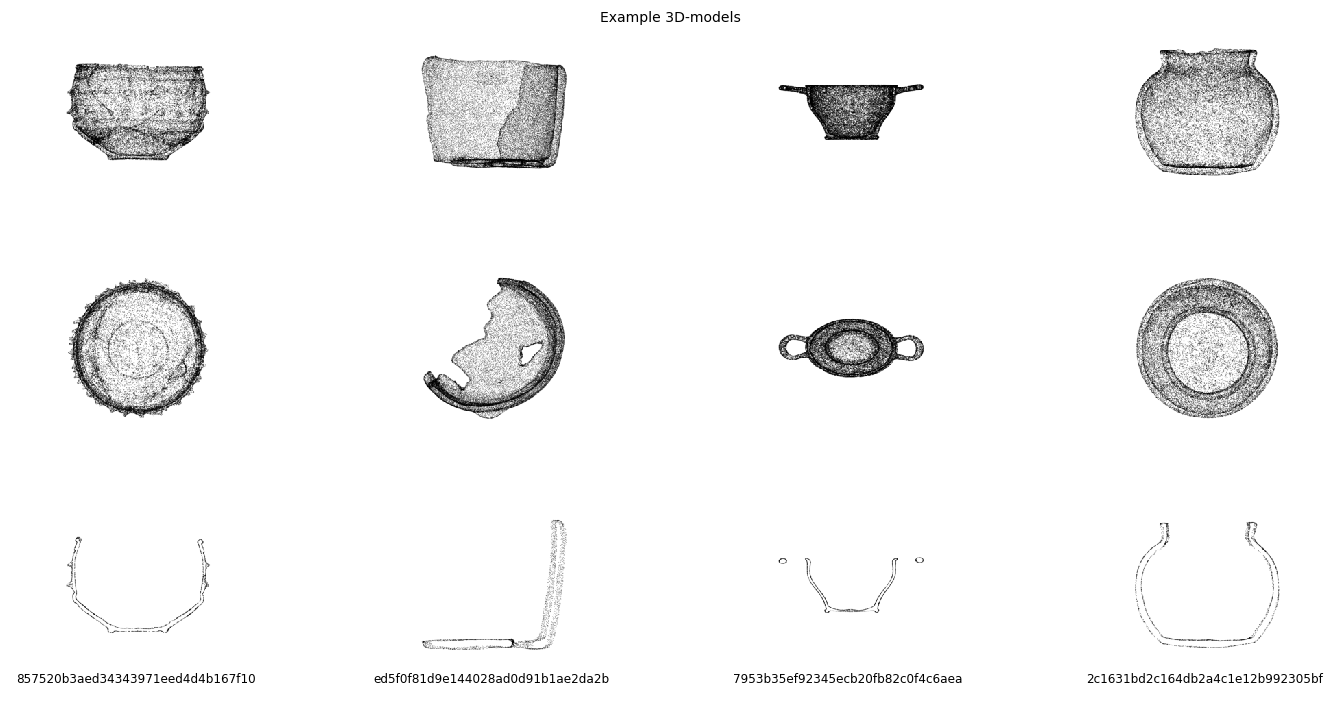

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import random 

# select some 3D-models at random
num_models = 4
fig, ax = plt.subplots(3, num_models, figsize=(20, 10))

for i in range(num_models):
    # select random 3D-model
    idx = random.randrange(len(vertices))
    # elevation views
    ax[0, i].imshow(rendered_elevation[idx].reshape(299, 299, 3), cmap=plt.cm.gray)
    ax[0, i].axis('off')
    # plan views
    ax[1, i].imshow(rendered_plan[idx].reshape(299, 299, 3), cmap=plt.cm.gray)
    ax[1, i].axis('off')
    # section views
    ax[2, i].imshow(rendered_section[idx].reshape(299, 299, 3), cmap=plt.cm.gray)
    ax[2, i].axis('off')
    # show 3D-model id
    model_uid = downloaded_uid[idx] #  a string identifying the model
    ax[2, i].set_title(model_uid, y=0)
plt.tight_layout()
fig.suptitle('Example 3D-models', fontsize=14)
plt.show();

## Save rendered point clouds and textures
The rendered point clouds (rendered_elevation, rendered_plan and rendered_section) and textures can now be saved as compressed npz files.

### Split
The data is split into training (70%), validation (20%) and test (10%) data, to  prevent overfitting.
The number of items per class is imbalanced (notebook 1, EDA), splitting the dataset takes this into account by setting the stratify parameter to the 'period' column.

In [18]:
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

metadata_tr, metadata_te = train_test_split(metadata_df, train_size=0.7, stratify=metadata_df['period'], random_state=0)
metadata_va, metadata_te = train_test_split(metadata_te, train_size=0.66, stratify=metadata_te['period'], random_state=0)
print('The training dataset has {} entries, the validation dataset {}, the testing dataset {}.'.format(len(metadata_tr), len(metadata_va), len(metadata_te)))

The training dataset has 677 entries, the validation dataset 192, the testing dataset 99.


The distribution of items per 'period' class in each dataset are shown in the plot below. Grafically, they apear to be roughly the same, as expected.

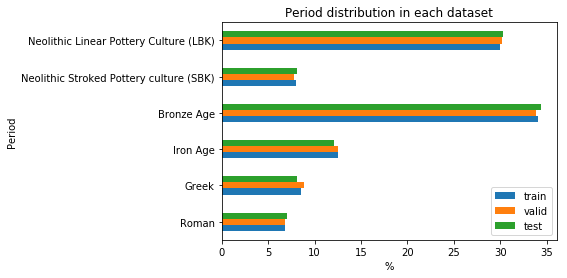

In [19]:
import matplotlib.pyplot as plt

# count items by period
counts = pd.DataFrame()
# training dataset
counts['train'] = 100*metadata_tr['period'].value_counts() / len(metadata_tr)
# validation dataset
counts['valid'] = 100*metadata_va['period'].value_counts() / len(metadata_va)
# testing dataset
counts['test'] = 100*metadata_te['period'].value_counts() / len(metadata_te)

# reindex chronologically top to bottom
antiquity = [
    'Neolithic Linear Pottery Culture (LBK)', 'Neolithic Stroked Pottery culture (SBK)', 
    'Bronze Age', 'Iron Age', 'Greek', 'Roman'] # periods in chronological order
counts = counts.reindex(antiquity).iloc[::-1]

# horizontal bar plot
counts.plot.barh()
plt.xlabel('%')
plt.ylabel('Period')
plt.title('Period distribution in each dataset')
plt.show();

### Directory structure
The train, validation and test datasets can now be saved to compressed npz files.
The data directory structure looks like this:
```
test/                   # Test dataset (10%)
- point_clouds.npz
- textures.npz
train/                  # Training dataset (70%)
- point_clouds.npz
- textures.npz
validate/               # Validation dataset (20%)
- point_clouds.npz
- textures.npz
downloaded_metadata.csv # 3D-model metadata as it was obtained from Sketchfab
metadata.csv            # Cleaned-up metadata
rotation.csv            # Rotation required by each model
```

In [20]:
# TRAIN
TRAIN_DIR = 'data/train'

# filter train data
idx = [uid in list(metadata_tr['id']) for uid in metadata_df['id']]
# save rendered views to compressed file
np.savez_compressed(os.path.join(TRAIN_DIR, 'point_clouds.npz'),
         metadata = metadata_df[idx],
         elevation = rendered_elevation[idx],
         plan = rendered_plan[idx],
         section = rendered_section[idx]
        )
# save textures to compressed file
np.savez_compressed(os.path.join(TRAIN_DIR, 'textures.npz'),
         metadata = metadata_df[idx],
         texture = textures[idx]
        )

# VALIDATE
VALIDATE_DIR = 'data/validate'

# filter validation data
idx = [uid in list(metadata_va['id']) for uid in metadata_df['id']]
# save rendered views to compressed file
np.savez_compressed(os.path.join(VALIDATE_DIR, 'point_clouds.npz'),
         metadata = metadata_df[idx],
         elevation = rendered_elevation[idx],
         plan = rendered_plan[idx],
         section = rendered_section[idx]
        )
# save textures to compressed file
np.savez_compressed(os.path.join(VALIDATE_DIR, 'textures.npz'),
         metadata = metadata_df[idx],
         texture = textures[idx]
        )

# TEST
TEST_DIR = 'data/test'

# filter test data
idx = [uid in list(metadata_te['id']) for uid in metadata_df['id']]
# save rendered views to compressed file
np.savez_compressed(os.path.join(TEST_DIR, 'point_clouds.npz'),
         metadata = metadata_df[idx],
         elevation = rendered_elevation[idx],
         plan = rendered_plan[idx],
         section = rendered_section[idx]
        )
# save textures to compressed file
np.savez_compressed(os.path.join(TEST_DIR, 'textures.npz'),
         metadata = metadata_df[idx],
         texture = textures[idx]
        )


# 